In [ ]:
import sys
sys.path.append('..')

# **1.1. - RNN (*Recurrent Neural Networks*) + GloVe (*Global Vectors for Word Representation*)**

In this notebook, we will use the same RNN model as in the previous notebook (`1-RNN.ipynb`), but we will use a different word embedding technique. More specifically, instead of using our own word embedding, which is trained from scratch, we will use a pre-trained word embedding technique called GloVe (*Global Vectors for Word Representation*).

<p align="left">
<img src="https://miro.medium.com/v2/resize:fit:1400/1*GJIk9Uv9-Tjwq8184slCHQ.png"/>
</p>

*Figure 1: [Intuitive Guide to Understanding GloVe Embeddings](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010), Thushan Ganegedara, Towards Data Science, 2019.*

GloVe is a pre-trained word embedding model that maps words to high-dimensional vector representations. It is based on the distributional hypothesis, which states that words that appear in similar contexts tend to have similar meanings.

The GloVe model uses a co-occurrence matrix to capture the statistical relationships between words. The matrix is constructed by counting the number of times each word appears in the same context as every other word in a large corpus of text. The rows and columns of the matrix correspond to the words in the vocabulary, and the entries in the matrix represent the co-occurrence counts.

The GloVe model then factorizes the co-occurrence matrix to obtain a low-dimensional vector representation for each word that captures its semantic and syntactic properties. The resulting vectors can be used as inputs to a neural network for various natural language processing tasks, such as sentiment analysis, language translation, and named entity recognition.

<p align="left">
<img src="https://i.stack.imgur.com/oJEie.png"/>
</p>

*Figure 1: [Example of co-ocurrence matrix](https://blog.mlreview.com/understanding-lstm-and-its-diagrams-37e2f46f1714), 7 Hidden Layers*

One advantage of using pre-trained word embeddings like GloVe is that they can save a significant amount of time and computational resources compared to training a custom word embedding from scratch. Training a custom word embedding requires a large amount of text data and a powerful computer, which is not feasible in all contexts. Additionally, pre-trained word embeddings like GloVe have been trained on large, diverse corpora of text, which may capture a wider range of language patterns than a smaller, domain-specific corpus.

Another advantage of using pre-trained word embeddings like GloVe is that they can improve the performance of a model on downstream tasks. This is because the pre-trained embeddings already contain information about the relationships between words, which can help the model generalize to new data more effectively. In contrast, training a custom word embedding from scratch may require more data and tuning to achieve comparable performance.

However, there are also some scenarios where it may be better to train a custom word embedding from scratch. For example, if the task requires specific domain knowledge or language patterns that are not captured by the pre-trained embeddings, training a custom embedding may be necessary. Additionally, if the pre-trained embeddings were trained on a corpus of text that is significantly different from the target domain, the performance of the model may suffer.

Therefore, the decision to use GloVe or train a custom embedding should depend on the specific requirements of the task and the availability of resources.

**Source**: [Intuitive Guide to Understanding GloVe Embeddings](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010), Thushan Ganegedara, Towards Data Science, 2019.

Let's load the required libraries in order to run the code:

In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, SimpleRNN, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from src.data_exploration.data_preprocessing import train_test_split, tokenization, load_glove_embeddings, create_embedding_matrix
from src.utils.eval_utils import plot_metric_curves, plot_confusion_matrix

## Load dataset

Now let's load the dataset generated in `0-EDA.ipynb`:

In [2]:
dataset = os.path.join("../data", "Sarcasm_Headlines_Dataset_v2.csv")

df = pd.read_csv(dataset, sep=";")
df.head()

,headline,label
0,scientist unveil doomsday clock hair loss,1
1,dem rep totally nail congress falling short ge...,0
2,eat different recipe,0
3,weather prevents liar getting work,1
4,mother come pretty close using word streaming ...,1


## Split data into train and validation sets

We need to generate both training and validation sets. We will use 80% of the data for training and the remaining 20% for validation. Moreover, in classification tasks it is important to maintain the same proportion of classes in both training and validation sets (otherwise, the model might be affected by it during the training process, and the validation metrics may also be distorted). `scikit-learn` offers the class `StratifiedShuffleSplit` for achieving this, which will be used. We have developed the `train_test_split` function, which is stored in `src/data_exploration/data_preprocessing.py`:

In [3]:
X_train, y_train, X_val, y_val = train_test_split(df, "label")

Let's check that the training set contains 80% of data:

In [4]:
np.round(len(X_train) / len(df), 2)

0.8

Let's also check that the distribution of classes in both sets are almost the same:

In [5]:
y_train.value_counts(normalize=True)

label
0    0.518145
1    0.481855
Name: proportion, dtype: float64

In [6]:
y_val.value_counts(normalize=True)

label
0    0.518237
1    0.481763
Name: proportion, dtype: float64

# Tokenization, Padding and Sequencing

In [7]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val, "headline") 

## Build the model

In order to use the pre-trained GloVe embeddings, we need to download it. For doing so, execute the following command in the terminal:

```bash
wget http://nlp.stanford.edu/data/glove.6B.zip
```

Then, unzip the file by using the command below:

```bash
unzip -q glove.6B.zip
```

The zip can also be downloaded from [here](https://nlp.stanford.edu/projects/glove/). We have already added the unzipped files to the `data` folder, and therefore it is time to load them.

***Note***: *for all models we we will use the 100-dimensional version of the GloVe embeddings. We trained them with the 200 and 300-dimensional versions, but the results were not significantly better, so we decided to use the 100-dimensional version for the sake of simplicity.*

In [8]:
num_tokens = vocab_size + 1
# Define embedding dimension for GloVe (this is needed in order to load the corresponding embeddings)
embedding_dim = 100

path_to_glove_file = os.path.join("../data", f"glove.6B.{embedding_dim}d.txt")

In [9]:
embeddings_index = load_glove_embeddings(path_to_glove_file)
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [10]:
embedding_matrix, hits, misses = create_embedding_matrix(embeddings_index, tokenizer, num_tokens, embedding_dim)
print(f"Converted {hits} words ({misses} misses)")

Converted 7532 words (138 misses)


In [11]:
model = Sequential()

# Embedding layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    # input_length=max_seq_len,
    trainable=False,
)

model.add(embedding_layer)

# Add SimpleRNN layer
model.add(SimpleRNN(128, recurrent_dropout=0.5, dropout=0.5))

# Flatten and Dense Layer
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))

# Output layer
model.add(Dense(1, activation="sigmoid"))

In [12]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         767200    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 804,833
Trainable params: 37,633
Non-train

## Train the model

Let's first create a folder where to save our models.

In [14]:
# Create directory where to save the models created
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

In [15]:
# Model name and path
model_path = os.path.join(models_dir, "rnn_glove_model.h5")

We use `EarlyStopping` to limit *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training. We will using validation loss as metric function for early stopping, setting a patience of 5 (i.e., we will stop after there is no improvement in validation loss for 5 epochs of training). Since we are dealing with a relatively small dataset, we can set a high enough number of epochs, as we can be fairly sure that training will be stopped before reaching the limit.

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [17]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_data=(val_padded, np.array(y_val)),
    callbacks = [es, mc]
)

Epoch 1/30
335/338 [============================>.] - ETA: 0s - loss: 0.7092 - acc: 0.5071
Epoch 1: val_loss improved from inf to 0.69173, saving model to models\rnn_glove_model.h5
338/338 [==============================] - 13s 26ms/step - loss: 0.7092 - acc: 0.5070 - val_loss: 0.6917 - val_acc: 0.5145
Epoch 2/30
335/338 [============================>.] - ETA: 0s - loss: 0.7008 - acc: 0.5118
Epoch 2: val_loss did not improve from 0.69173
338/338 [==============================] - 6s 17ms/step - loss: 0.7009 - acc: 0.5116 - val_loss: 0.6939 - val_acc: 0.5023
Epoch 3/30
337/338 [============================>.] - ETA: 0s - loss: 0.6967 - acc: 0.5227
Epoch 3: val_loss improved from 0.69173 to 0.67914, saving model to models\rnn_glove_model.h5
338/338 [==============================] - 8s 23ms/step - loss: 0.6967 - acc: 0.5227 - val_loss: 0.6791 - val_acc: 0.5597
Epoch 4/30
335/338 [============================>.] - ETA: 0s - loss: 0.6908 - acc: 0.5354
Epoch 4: val_loss improved from 0.6791

## Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

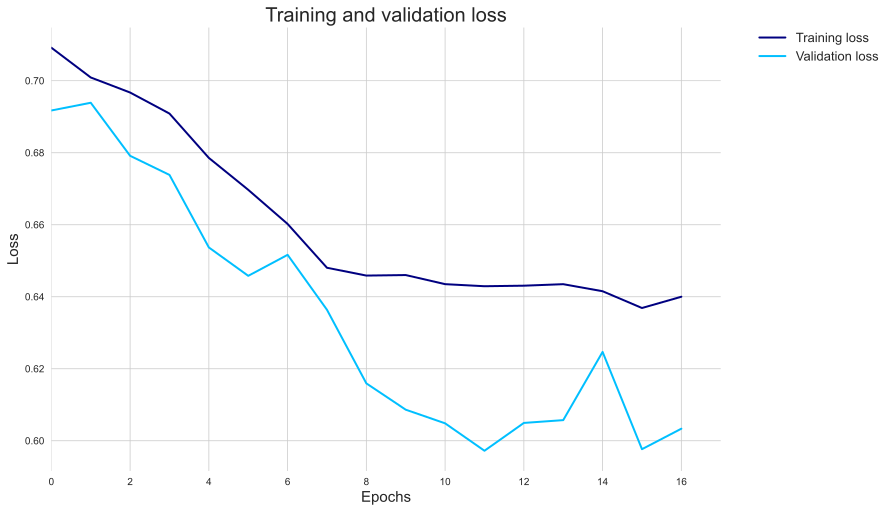

In [19]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "navy", "deepskyblue", "Loss", 2)

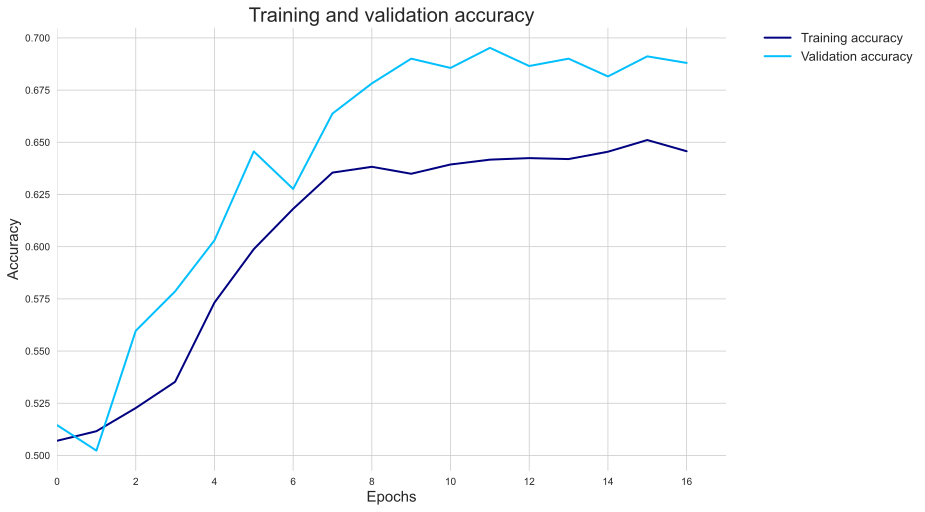

In [20]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "navy", "deepskyblue", "Accuracy", 2)

The plots above reveal an interesting phenomenon: the loss and accuracy values for the validation set consistently outperform those of the training set.

Unlike the previous notebook that used a custom word embedding with slow learning rates, the training and validation loss for this model started decreasing rapidly from the outset. However, the difference between the training and validation loss increased significantly after the 15th epoch. Subsequently, after the 21st epoch, the validation loss did not improve while the training loss continued to decrease.

The saved model has a validation loss of 0.57 and a validation accuracy of 0.71. In the following section, we will evaluate the model's performance on unseen data and compare its loss and accuracy with those obtained on the validation set.

## Evaluate model

Let's finally see how well the model performs with unseen data. Firstly, we will load the test set:

In [21]:
test_set = os.path.join("../data", "Sarcasm_Headlines_Dataset_OOS_Prep.csv")
df_test = pd.read_csv(test_set, sep=";")
df_test.head()

,headline,label
0,nextdoor ceo recruit army fanatic holy crusade...,1
1,exclusive interview clarence thomas,1
2,pro con banning book,1
3,know train derailment toxic chemical ohio,1
4,cia criticized use abusive etiquette coach bla...,1


In [22]:
df_test.shape

(2003, 2)

And then we need to create both $X_{test}$ and $y_{test}$:

In [23]:
# Get X_test and y_test
X_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

Finally, we need to apply the same preprocessing steps that we applied to the training set (tokenization, padding and sequencing):

In [24]:
# Apply tokenizer to test set
test_sequences = tokenizer.texts_to_sequences(X_test["headline"])
test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

Let's also load the best model obtained during training:

In [25]:
rnn_model = load_model(model_path)

We can now evaluate the model with the test set:

In [26]:
# Evaluate model on test set
loss_test, acc_test = rnn_model.evaluate(test_padded, np.array(y_test))
print("Test loss: {:.4f}".format(loss_test))
print("Test accuracy: {:.4f}".format(acc_test))

63/63 [==============================] - 1s 3ms/step - loss: 0.6936 - acc: 0.5921
Test loss: 0.6936
Test accuracy: 0.5921


63/63 [==============================] - 1s 3ms/step


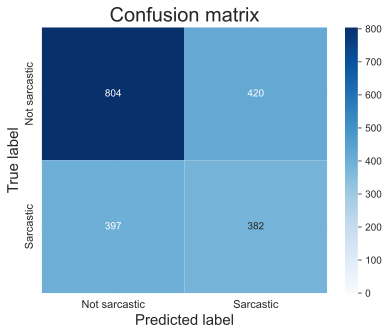

In [27]:
predictions = rnn_model.predict(test_padded)
conf_matrix = confusion_matrix(y_test, np.round(predictions))
plot_confusion_matrix(conf_matrix, ["Not sarcastic", "Sarcastic"], "Blues")

In [28]:
conf_matrix

array([[804, 420],
       [397, 382]], dtype=int64)

In [29]:
print(classification_report(y_test, np.round(predictions)))

              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1224
           1       0.48      0.49      0.48       779

    accuracy                           0.59      2003
   macro avg       0.57      0.57      0.57      2003
weighted avg       0.59      0.59      0.59      2003



As observed, this model also suffers from overfitting, with a test accuracy almost identical to the previous model.

Despite having a validation accuracy of 0.71, the test accuracy is only 0.58, indicating that the model has not generalized well. One possible reason for overfitting could be that the test set includes headlines from different sources than those used for training, which may affect the model's performance due to varying vocabulary and topics.

Upon examining the confusion matrix, we find that the model has a higher number of false negatives than false positives, implying that it has difficulty in detecting sarcasm in headlines that are sarcastic. In comparison to the previous model, this model has fewer false negatives (429 vs. 479), but more false positives (142 vs. 87).

In conclusion, using GloVe does not appear to improve the model's performance compared to custom word embeddings.